In [1]:
!nvidia-smi

Wed Oct 18 18:06:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:0


In [4]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label='Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()

    val_acc_history_cpu = [x.cpu() for x in val_acc_history]
    plt.plot(val_acc_history_cpu, label='Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

In [5]:
def plot_data_sub(val_acc_history, loss_acc_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(loss_acc_history, label='Validation')
    ax1.set_title('Loss per epoch')
    ax1.legend()

    val_acc_history_cpu = [x.cpu() for x in val_acc_history]
    ax2.plot(val_acc_history_cpu, label='Validation')
    ax2.set_title('Accuracy per epoch')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [6]:
def plot_results(train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, num_epochs, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    # Plot training and validation loss
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    # Plot training and validation accuracy
    plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), valid_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.suptitle(model_name)
    plt.show()


In [7]:
def plot_data_loos_acc(model_name, num_epochs, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    # Plot training and validation loss
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    # Plot training and validation accuracy
    plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), valid_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.suptitle(model_name)
    plt.show()

In [8]:
# Set up preprocessing of CIFAR-10 images to 3x224x224 with normalization
# using the magic ImageNet means and standard deviations. You can try
# RandomCrop, RandomHorizontalFlip, etc. during training to obtain
# slightly better generalization.

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=preprocess)

# Split the training set into training and validation sets randomly.
# CIFAR-10 train contains 50,000 examples, so let's split 80%/20%.

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

# Download the test set. If you use data augmentation transforms for the training set,
# you'll want to use a different transformer here.

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

# Dataset objects are mainly designed for datasets that can't fit entirely into memory.
# Dataset objects don't load examples into memory until their __getitem__() method is
# called. For supervised learning datasets, __getitem__() normally returns a 2-tuple
# on each call. To make a Dataset object like this useful, we use a DataLoader object
# to optionally shuffle then batch the examples in each dataset. During training.
# To keep our memory utilization small, we'll use 4 images per batch, but we could use
# a much larger batch size on a dedicated GPU. To obtain optimal usage of the GPU, we
# would like to load the examples for the next batch while the current batch is being
# used for training. DataLoader handles this by spawining "worker" threads that proactively
# fetch the next batch in the background, enabling parallel training on the GPU and data
# loading/transforming/augmenting on the CPU. Here we use num_workers=2 (the default)
# so that two batches are always ready or being prepared.

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                             shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                              shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:10<00:00, 15831297.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.

            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the train/validation dataset according to which phase we're in

            for inputs, labels in dataloaders[phase]:

                # Inputs is one batch of input images, and labels is a corresponding vector of integers
                # labeling each image in the batch. First, we move these tensors to our target device.

                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out any parameter gradients that have previously been calculated. Parameter
                # gradients accumulate over as many backward() passes as we let them, so they need
                # to be zeroed out after each optimizer step.

                optimizer.zero_grad()

                # Instruct PyTorch to track gradients only if this is the training phase, then run the
                # forward propagation and optionally the backward propagation step for this iteration.

                with torch.set_grad_enabled(phase == 'train'):
                    # The inception model is a special case during training because it has an auxiliary
                    # output used to encourage discriminative representations in the deeper feature maps.
                    # We need to calculate loss for both outputs. Otherwise, we have a single output to
                    # calculate the loss on.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backpropagate only if in training phase

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()

            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    # Output summary statistics, load the best weight set, and return results

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

In [10]:
class AlexNetModule(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
alexnet = AlexNetModule(10)
alexnet = alexnet.to(device)

In [12]:
# Using CrossEntropyLoss for multinomial classification (Because we have 10 classes)
criterion = nn.CrossEntropyLoss()
# parameters = weights
params_to_update = alexnet.parameters()
# Use scholastic gradient descent for update weights in model with learning rate 0.001 and momentum 0.9
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [13]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

In [14]:

best_model, val_acc_history, loss_acc_history = train_model(alexnet, dataloaders, criterion, optimizer, 50, 'alex_sequential_lr_0.001_bestsofar')


Epoch 0/49
----------
train Loss: 2.3004 Acc: 0.1150
Epoch time taken:  46.182127475738525
val Loss: 2.2915 Acc: 0.1286
Epoch time taken:  55.58980894088745

Epoch 1/49
----------
train Loss: 2.1255 Acc: 0.2124
Epoch time taken:  39.23051118850708
val Loss: 1.9126 Acc: 0.3181
Epoch time taken:  48.654441356658936

Epoch 2/49
----------
train Loss: 1.7878 Acc: 0.3419
Epoch time taken:  39.86481976509094
val Loss: 1.6680 Acc: 0.3956
Epoch time taken:  49.335160970687866

Epoch 3/49
----------
train Loss: 1.6090 Acc: 0.4045
Epoch time taken:  39.651798486709595
val Loss: 1.5213 Acc: 0.4407
Epoch time taken:  49.1481192111969

Epoch 4/49
----------
train Loss: 1.4825 Acc: 0.4563
Epoch time taken:  39.87878394126892
val Loss: 1.4104 Acc: 0.4838
Epoch time taken:  49.25736212730408

Epoch 5/49
----------
train Loss: 1.3792 Acc: 0.4986
Epoch time taken:  39.78267049789429
val Loss: 1.3928 Acc: 0.5068
Epoch time taken:  49.22571921348572

Epoch 6/49
----------
train Loss: 1.2929 Acc: 0.5350
Ep

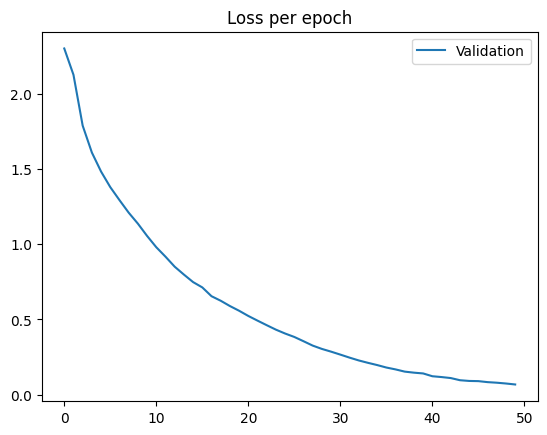

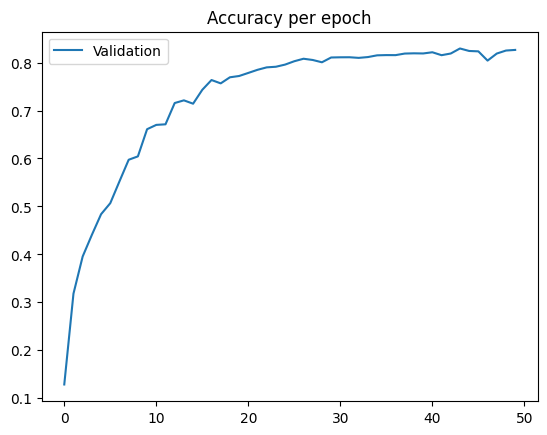

In [15]:
plot_data(val_acc_history, loss_acc_history)

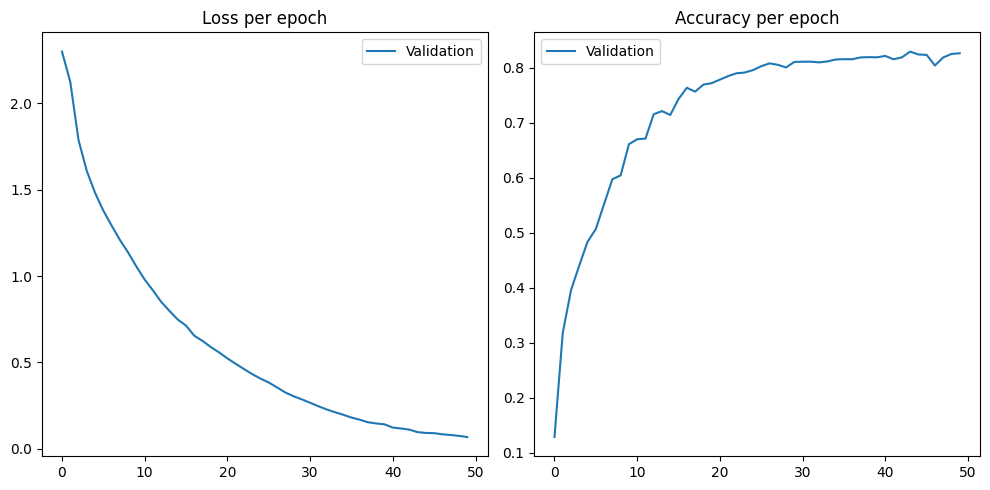

In [16]:
plot_data_sub(val_acc_history, loss_acc_history)

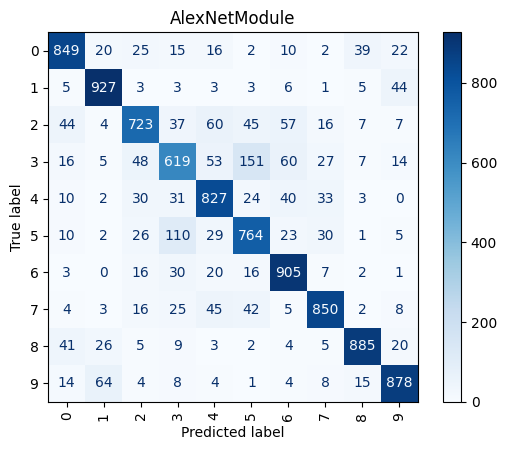

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

loaded_model = AlexNetModule()
loaded_model.load_state_dict(torch.load('/content/alex_sequential_lr_0.001_bestsofar.pth'))
loaded_model.to(device)  # Move the loaded model to the same device as the data

# Test the loaded model
def test_loaded_model(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Test the loaded model
all_preds, all_labels = test_loaded_model(loaded_model, test_dataloader, device)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix using ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
cmd.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("AlexNetModule")
# Show the plot
plt.show()